In [ ]:
import warnings
warnings.filterwarnings("ignore")

# Отключим логирование в Prophet

import logging

logging.getLogger("prophet").setLevel(logging.WARNING)
logging.getLogger("cmdstanpy").disabled=True


In [50]:
!pip install etna[all]

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 23.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 34.1 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8793 sha256=ea89fa144ce9735df7da317b3da283ad42316c988a9c43eda57f3e8204dd9e99
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools
  Attempting uninstall: protobuf
    Found existing installation: protobuf 4.25.5
    Uninstalling protobuf-4.25.5:
      Successfully uninstalled protobuf-4.25.5
  Attempting uninstall: wandb
    Found existing installation: wandb 0.18.7
    Uninstalling wandb-0.18.7:
      Successfully uninstalled wandb-0.18.7
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
grpcio-status 1.62.3 requ

In [3]:
# Параметры кросс-валидации

from etna.metrics import SMAPE

HORIZON = 31
N_FOLDS = 3

def eval_pipeline(pipeline):
    metrics_df, forecast_df, fold_info_df = pipeline.backtest(
        ts=ts, n_folds=N_FOLDS, metrics=[SMAPE()], aggregate_metrics=True
    )
    return metrics_df.mean()


In [4]:
pip install etna[torch]

In [ ]:
!pip install etna[statsforecast]
!pip install etna[classification]

  Using cached statsforecast-1.4.0-py3-none-any.whl.metadata (19 kB)
Using cached statsforecast-1.4.0-py3-none-any.whl (91 kB)
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 60.8/60.8 kB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.5/2.5 MB 34.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 95.8/95.8 kB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.2/41.2 MB 21.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 176.5/176.5 kB 9.9 MB/s eta 0:00:00
  Attempting uninstall: scipy
    Found existing installation: scipy 1.13.1
    Uninstalling scipy-1.13.1:
      Successfully uninstalled scipy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
gensim 4.3.3 requires scipy<1.14.0,>=1.7.0, but you have scipy 1.14.1 which is incompatible.
mizani 0.13.1 requires pandas>=2.2.0, but you have pandas 1.

# Загрузка данных

В этом задании мы попробуем улучшить качество модели прогнозирования засчет удаления аномалий из обучающего датасета

Для начала загрузим чистые данные и построим на них базовый пайплайн

In [5]:
import pandas as pd
from etna.datasets.tsdataset import TSDataset
from etna.pipeline import Pipeline
from etna.models import ProphetModel

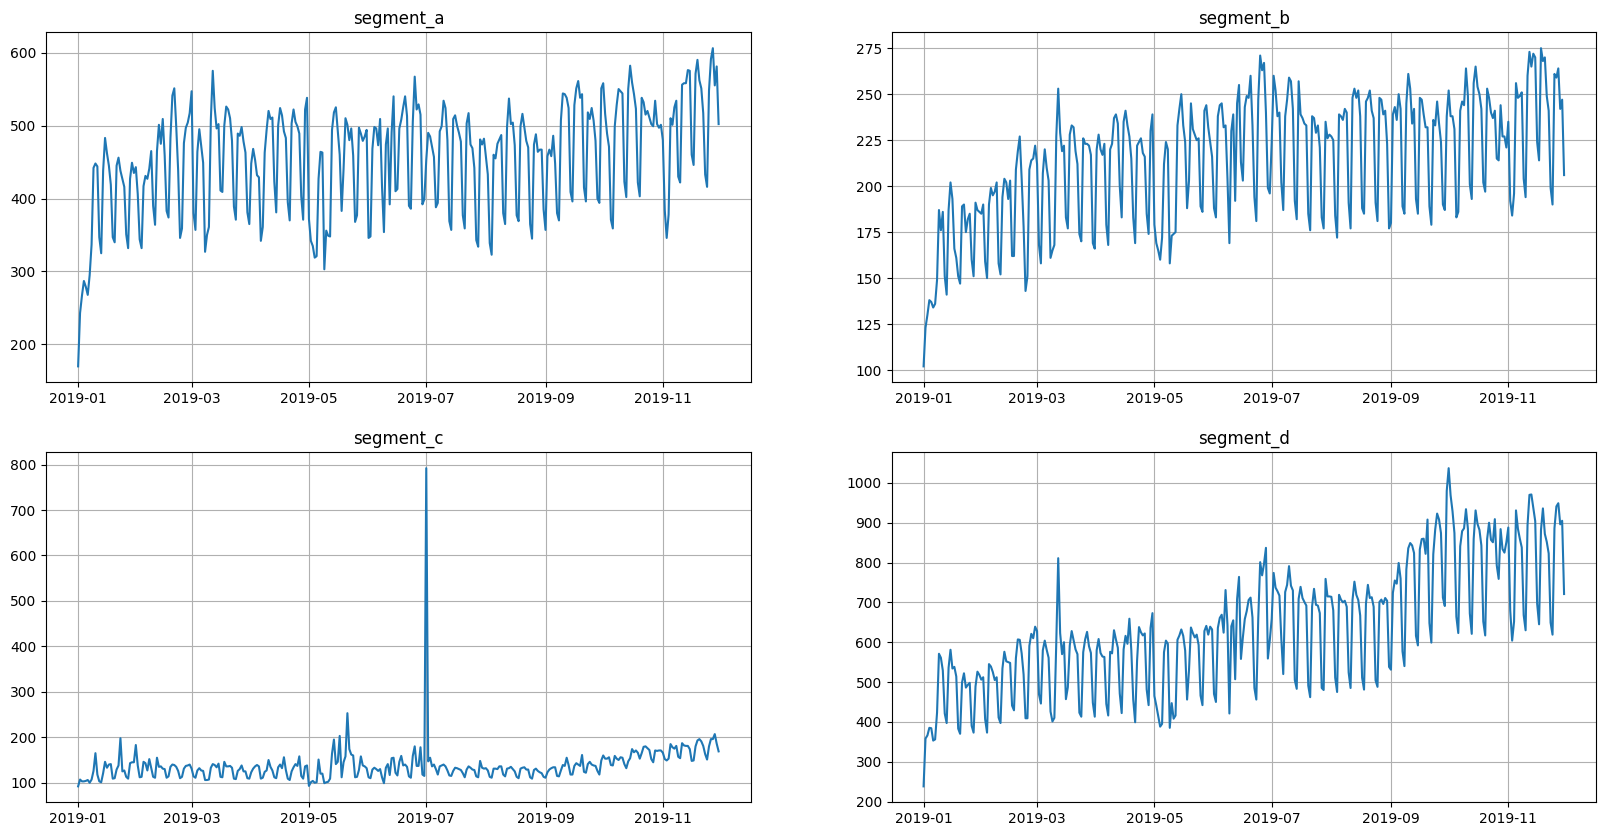

In [6]:
df = pd.read_csv("example_dataset.csv")
ts = TSDataset(df=df, freq="D")
ts.plot()

Можем считать, что это базовая метрика, к которой мы дальше будем стремиться

In [7]:
base_pipeline = Pipeline(
    model=ProphetModel(),
    transforms=[],
    horizon=HORIZON
)
base_metric = eval_pipeline(base_pipeline)
base_metric

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/2vdgvxm5.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/fvu__wtq.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=38740', 'data', 'file=/tmp/tmp7tl9f3mn/2vdgvxm5.json', 'init=/tmp/tmp7tl9f3mn/fvu__wtq.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_model9yhe6w27/prophet_model-20241215143301.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:01 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:01 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

,0
SMAPE,8.435081


# Загрузка данных с аномалиями

Каким-то неизвестным образом в обучающей части датасета появились аномалии(их в целом видно на картинке). Давайте оценим насколько испортилась модель в их присутствии

**Важно:** на тестовой части датасета(где оценивается метрика) аномалий нет

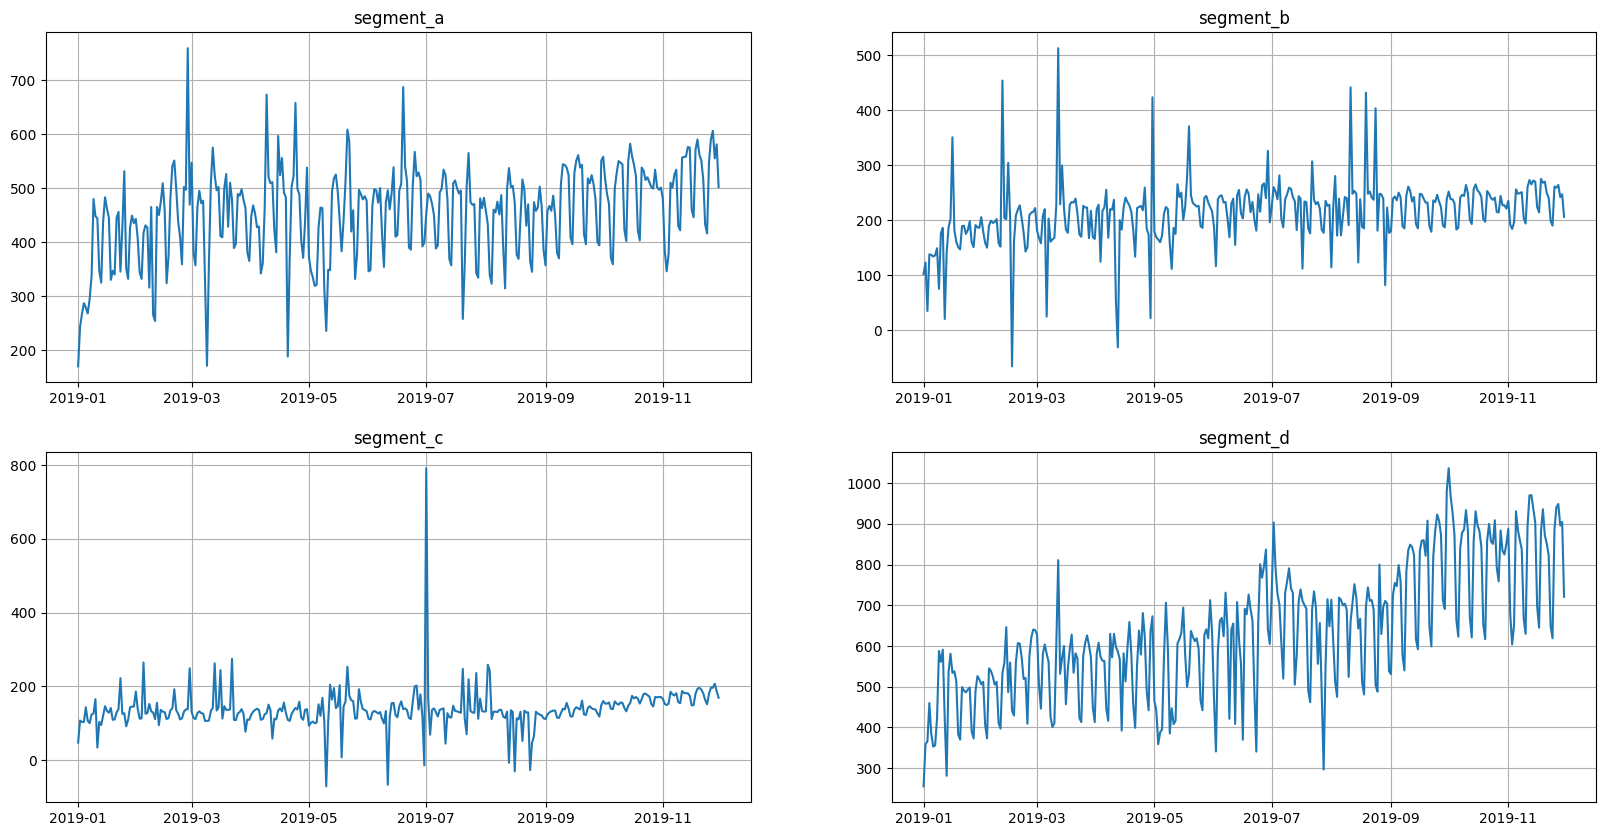

In [8]:
df = pd.read_csv("example_dataset_with_anomalies.csv")
ts = TSDataset(df=df, freq="D")
ts.plot()

Метрика стала чуть хуже -- в основной части задания вашей задачей будет это исправить

In [9]:
base_metric_with_anomalies = eval_pipeline(base_pipeline)
base_metric_with_anomalies

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/b695pk6g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/awmu8spr.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=8419', 'data', 'file=/tmp/tmp7tl9f3mn/b695pk6g.json', 'init=/tmp/tmp7tl9f3mn/awmu8spr.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_models3f1ko1v/prophet_model-20241215143313.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:33:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:33:13 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonality

,0
SMAPE,10.253328


# Удаление аномалий с дефолтными гиперпараметрами(3 балла)

Попробуем несоклько методов поиска точечных аномалий, которые разбирались на лекции:
- `MedianOutliersTransform` -- в окне оцениваются параметры номарльного распределения, все что выходит за $median + alpha * std$ аномалии
- `DensityOutliersTransform` -- для каждой точки строится несколько окон в центром с ней $y + alpha * std$, если ни в одном окне нет хотябы $n\_neighbors$ соседей точка считается аномалией
- `PredictionIntervalOutliersTransform` -- все что выходит за доверительные интервалы пронозной модели аномалии

С помощью `*OutliersTransform` можно найти и заменить точечные аномалии на `NaN`. Для некоторых моделей получившиеся пропуски необходимо заполянть, однако Prophet умеет работать с пропущенными значениями -- поэтому сфокусируемся только на поиске аномалий

Постройте пайплайн с выделением аномалий через 3 данных метода с дефолтными гиперпараметрами и оцените качество прогнозов

(За каждый метод по баллу)

In [10]:
from etna.transforms import MedianOutliersTransform, DensityOutliersTransform, PredictionIntervalOutliersTransform

In [30]:
# Инициализация DataFrame для хранения результатов
result = pd.DataFrame(columns=["method", "smape"])

# MedianOutliersTransform

In [31]:
from etna.models import ProphetModel

transforms = [
    MedianOutliersTransform(
        in_column="target",
    ),
]

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON
)

metrics = eval_pipeline(pipeline)

result = result.append({
    "method": "MedianOutliersTransform",
    "smape": metrics['SMAPE'],
}, ignore_index=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/6hi9nlwh.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/k_45usbe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=35332', 'data', 'file=/tmp/tmp7tl9f3mn/6hi9nlwh.json', 'init=/tmp/tmp7tl9f3mn/k_45usbe.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_modelyjpn0jo1/prophet_model-20241215144025.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:25 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:25 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

# DensityOutliersTransform

In [32]:
transforms = [
    DensityOutliersTransform(
        in_column="target",
    ),
]

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON
)

metrics = eval_pipeline(pipeline)

result = result.append({
    "method": "DensityOutliersTransform",
    "smape": metrics['SMAPE'],
}, ignore_index=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/jq_6uk2g.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/1d95hlio.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41961', 'data', 'file=/tmp/tmp7tl9f3mn/jq_6uk2g.json', 'init=/tmp/tmp7tl9f3mn/1d95hlio.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_model977em5zw/prophet_model-20241215144038.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:38 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:38 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

# PredictionIntervalOutliersTransform

In [33]:
transforms = [
    PredictionIntervalOutliersTransform (
        model=ProphetModel,
        in_column="target",
    ),
]

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=transforms,
    horizon=HORIZON
)

metrics = eval_pipeline(pipeline)

result = result.append({
    "method": "PredictionIntervalOutliersTransform",
    "smape": metrics['SMAPE'],
}, ignore_index=True)

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/1l8ijpil.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/dkb_e_bb.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=87576', 'data', 'file=/tmp/tmp7tl9f3mn/1l8ijpil.json', 'init=/tmp/tmp7tl9f3mn/dkb_e_bb.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_model38g2g7jc/prophet_model-20241215144045.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:40:45 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:40:45 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

In [34]:
result

,method,smape
0,MedianOutliersTransform,9.933816
1,DensityOutliersTransform,10.180599
2,PredictionIntervalOutliersTransform,8.506221


# Подберите гиперпараметры(6 баллов)
Теперь подберем отпимальные гиперпараметры наших методов(методы чувствительны к значениям гиперпараметров). На лекции качество методов оценивалось через классификационные метрики, однако в данном случае у нас нет на руках разметки. Предлагается подобрать гиперпараметры вторым методом -- по качеству решения задачи прогнозирования.

Для этого будем использовать механику перебора гиперпараметров на базе Optuna(подробнее тут https://github.com/etna-team/etna/blob/master/examples/205-automl.ipynb)

**В конце подведите итоги, какой метод оказался лучше?**

(За каждый метод по 2 балла)

In [35]:
from etna.distributions import FloatDistribution, IntDistribution, CategoricalDistribution
from etna.auto import Tune

In [36]:
def get_best_params(pipeline, params_to_tune):
    tune = Tune(
        pipeline=pipeline,
        target_metric=SMAPE(), horizon=HORIZON, backtest_params=dict(n_folds=3),
        params_to_tune=params_to_tune
    )
    best_params = tune.fit(ts=ts, n_trials=3, catch=(Exception, ))
    best_metic = tune.summary()["SMAPE_mean"].min()
    return best_params, best_metic

In [37]:
result['smape_tuned'] = None
result['best_params'] = None

# MedianOutliersTransform (tuned)

In [39]:
tranforms = [
    MedianOutliersTransform(
        in_column="target",
        window_size=5,  # Будет изменяться при подборе
        alpha=3.0       # Будет изменяться при подборе
    ),
]

params_to_tune = {
    "transforms.0.window_size": IntDistribution(low=3, high=30, step=1),
    "transforms.0.alpha": FloatDistribution(low=1.0, high=5.0, step=0.1),
}

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=tranforms,
    horizon=HORIZON
)

best_params, best_metric = get_best_params(pipeline, params_to_tune)

result.loc[result["method"] == "MedianOutliersTransform", "smape_tuned"] = best_metric
result.loc[result["method"] == "MedianOutliersTransform", "best_params"] = str(best_params)


[I 2024-12-15 14:41:24,731] A new study created in RDB with name: no-name-8559ab8c-cdb1-4646-aff5-6c95b04d9430
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/ph8v971r.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/3v2gli_4.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=2560', 'data', 'file=/tmp/tmp7tl9f3mn/ph8v971r.json', 'init=/tmp/tmp7tl9f3mn/3v2gli_4.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_modelv4mssthw/prophet_model-20241215144124.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:24 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:24 - cmdstanpy - INFO

In [40]:
print(f"best_params = {best_params}")
print(f"best_metric = {best_metric}")

best_params = {'transforms.0.alpha': 3.2, 'transforms.0.window_size': 19}
best_metric = 9.71900087450409


# DensityOutliersTransform (tuned)

In [41]:
tranforms = [
    DensityOutliersTransform(
        in_column="target",
        distance_coef=3.0,  # Будет изменяться при подборе
    ),
]

params_to_tune = {
    "transforms.0.distance_coef": FloatDistribution(low=1.0, high=5.0, step=0.1),
}

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=tranforms,
    horizon=HORIZON
)

best_params, best_metric = get_best_params(pipeline, params_to_tune)

result.loc[result["method"] == "DensityOutliersTransform", "smape_tuned"] = best_metric
result.loc[result["method"] == "DensityOutliersTransform", "best_params"] = str(best_params)


[I 2024-12-15 14:41:41,774] A new study created in RDB with name: no-name-5daa3c03-9e30-4128-98ab-bc287ea0b017
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/tl9qu4nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/o6ctqx3d.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=53100', 'data', 'file=/tmp/tmp7tl9f3mn/tl9qu4nn.json', 'init=/tmp/tmp7tl9f3mn/o6ctqx3d.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_modeljao9ccb1/prophet_model-20241215144141.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:41 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:42 - cmdstanpy - INF

# PredictionIntervalOutliersTransform (tuned)

In [42]:
tranforms = [
    PredictionIntervalOutliersTransform(
        in_column="target",
        model='prophet',
        interval_width=0.95
    ),
]

params_to_tune = {
    'transforms.0.interval_width': FloatDistribution(low=0.1, high=0.99, log=False),
    'model.weekly_seasonality': CategoricalDistribution([False, True]),
    'model.seasonality_mode': CategoricalDistribution(['additive', 'multiplicative']),
}

pipeline = Pipeline(
    model=ProphetModel(),
    transforms=tranforms,
    horizon=HORIZON
)

best_params, best_metric = get_best_params(pipeline, params_to_tune)

result.loc[result["method"] == "PredictionIntervalOutliersTransform", "smape_tuned"] = best_metric
result.loc[result["method"] == "PredictionIntervalOutliersTransform", "best_params"] = str(best_params)


[I 2024-12-15 14:41:55,646] A new study created in RDB with name: no-name-467a82ba-6f06-440e-9a9d-8aa70ed4e2ab
INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/_6qfuren.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/lop3udyo.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=79833', 'data', 'file=/tmp/tmp7tl9f3mn/_6qfuren.json', 'init=/tmp/tmp7tl9f3mn/lop3udyo.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_modelti534reb/prophet_model-20241215144155.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:41:55 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:41:55 - cmdstanpy - INF

In [47]:
result

,method,smape,smape_tuned,best_params
0,MedianOutliersTransform,9.933816,9.719001,"{'transforms.0.alpha': 3.2, 'transforms.0.wind..."
1,DensityOutliersTransform,10.180599,10.328124,{'transforms.0.distance_coef': 3.9000000000000...
2,PredictionIntervalOutliersTransform,8.506221,8.040276,"{'model.seasonality_mode': 'additive', 'model...."


# Выводы:

MedianOutliersTransform и PredictionIntervalOutliersTransform показали улучшение метрики SMAPE после подбора гиперпараметров.

Но DensityOutliersTransform выдала рост ошибки, после подбора. Возможной причиной может быть переобучение, дефолтные параметры являются более "общими", они мене чувствительны к локальным выбросам.


# Визуализируйте аномалии при оптимальных гиперпараметрах(1 балл)

Для того чтобы дополнительно убедиться что в итоге подобрались адекватные гиперпараметры, давайте визуализируем результаты

In [ ]:
from etna.analysis import plot_anomalies
from etna.analysis import get_anomalies_median, get_anomalies_density, get_anomalies_prediction_interval

In [51]:
result.set_index("method")["best_params"].to_dict()

{'MedianOutliersTransform': "{'transforms.0.alpha': 3.2, 'transforms.0.window_size': 19}",
 'DensityOutliersTransform': "{'transforms.0.distance_coef': 3.9000000000000004}",
 'PredictionIntervalOutliersTransform': "{'model.seasonality_mode': 'additive', 'model.weekly_seasonality': True, 'transforms.0.interval_width': 0.6748457606293239}"}

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/my26tfmx.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp7tl9f3mn/gk6ub3en.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.10/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=50600', 'data', 'file=/tmp/tmp7tl9f3mn/my26tfmx.json', 'init=/tmp/tmp7tl9f3mn/gk6ub3en.json', 'output', 'file=/tmp/tmp7tl9f3mn/prophet_modelvc4luqc8/prophet_model-20241215144548.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
14:45:48 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
14:45:48 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
INFO:prophet:Disabling yearly seasonalit

Визуализация аномалий на основе медианы:
Визуализация аномалий на основе плотности:
Визуализация аномалий на основе предиктивного интервала:


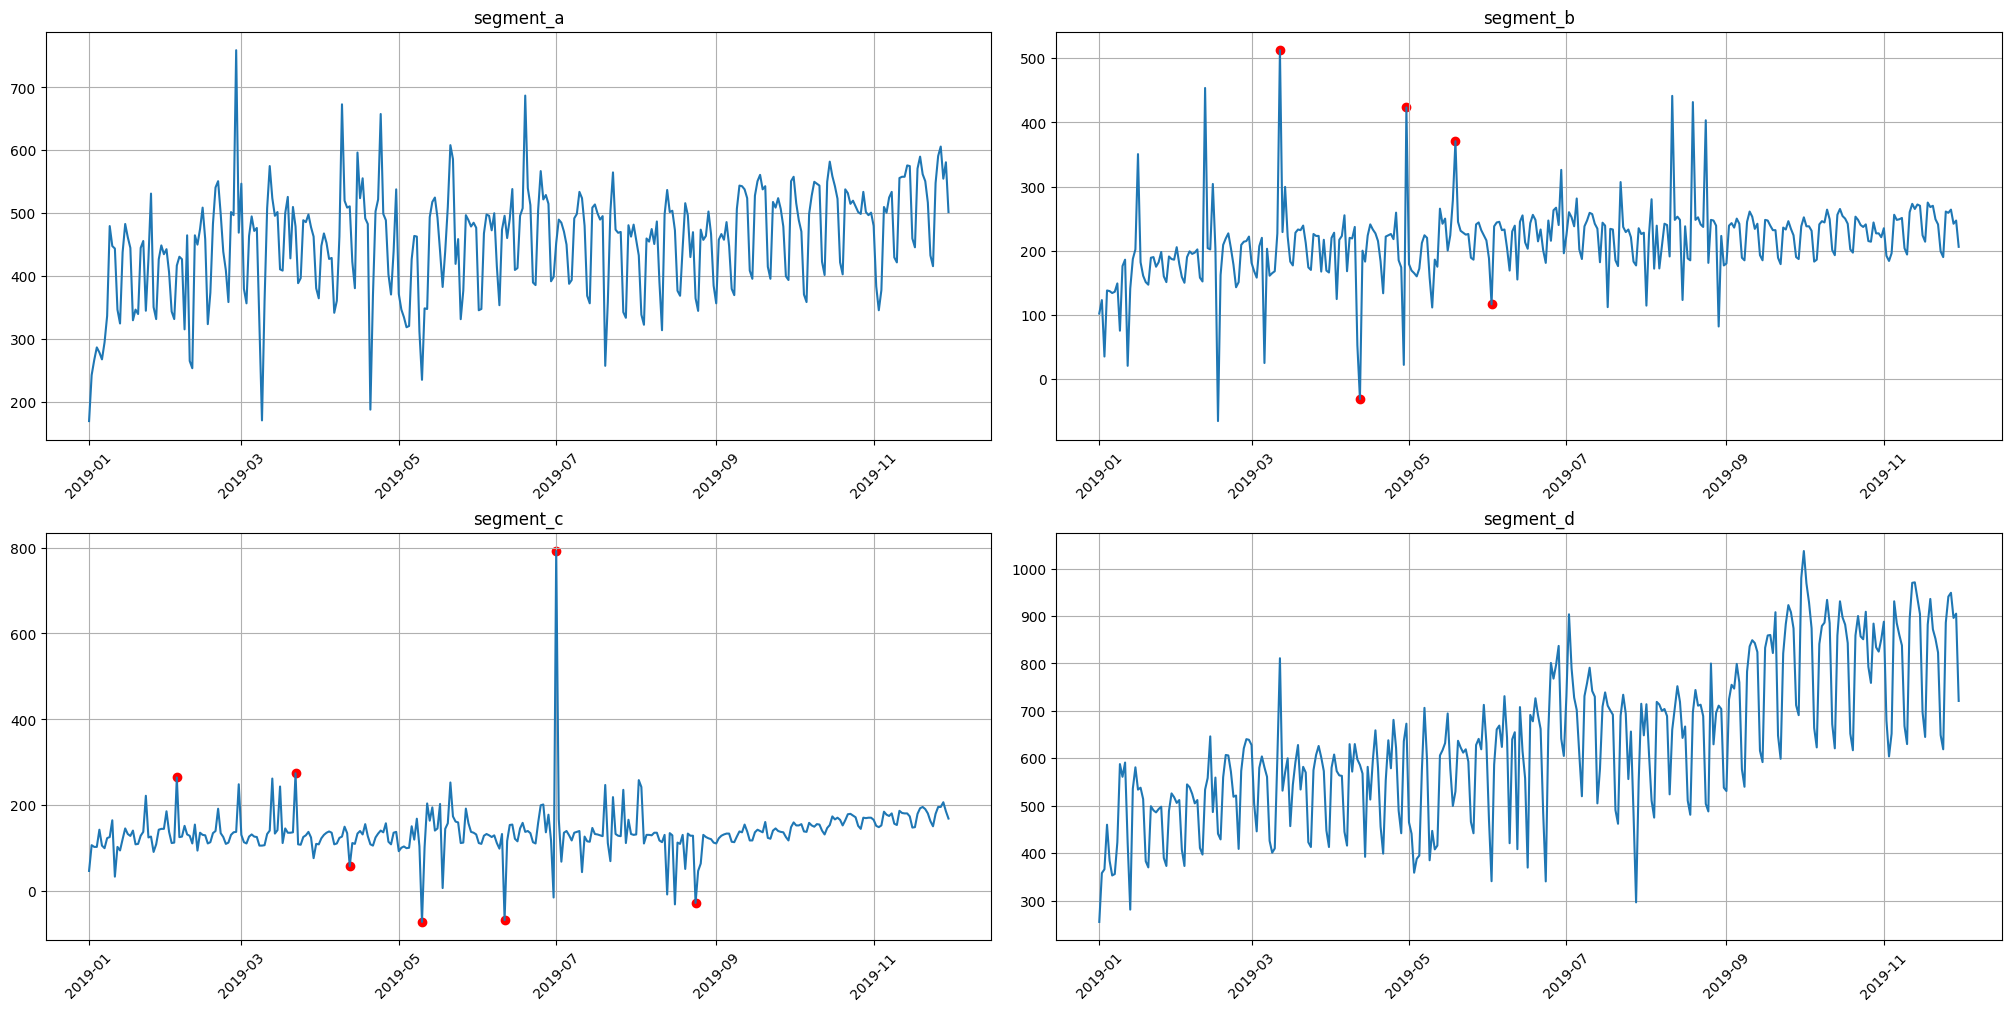

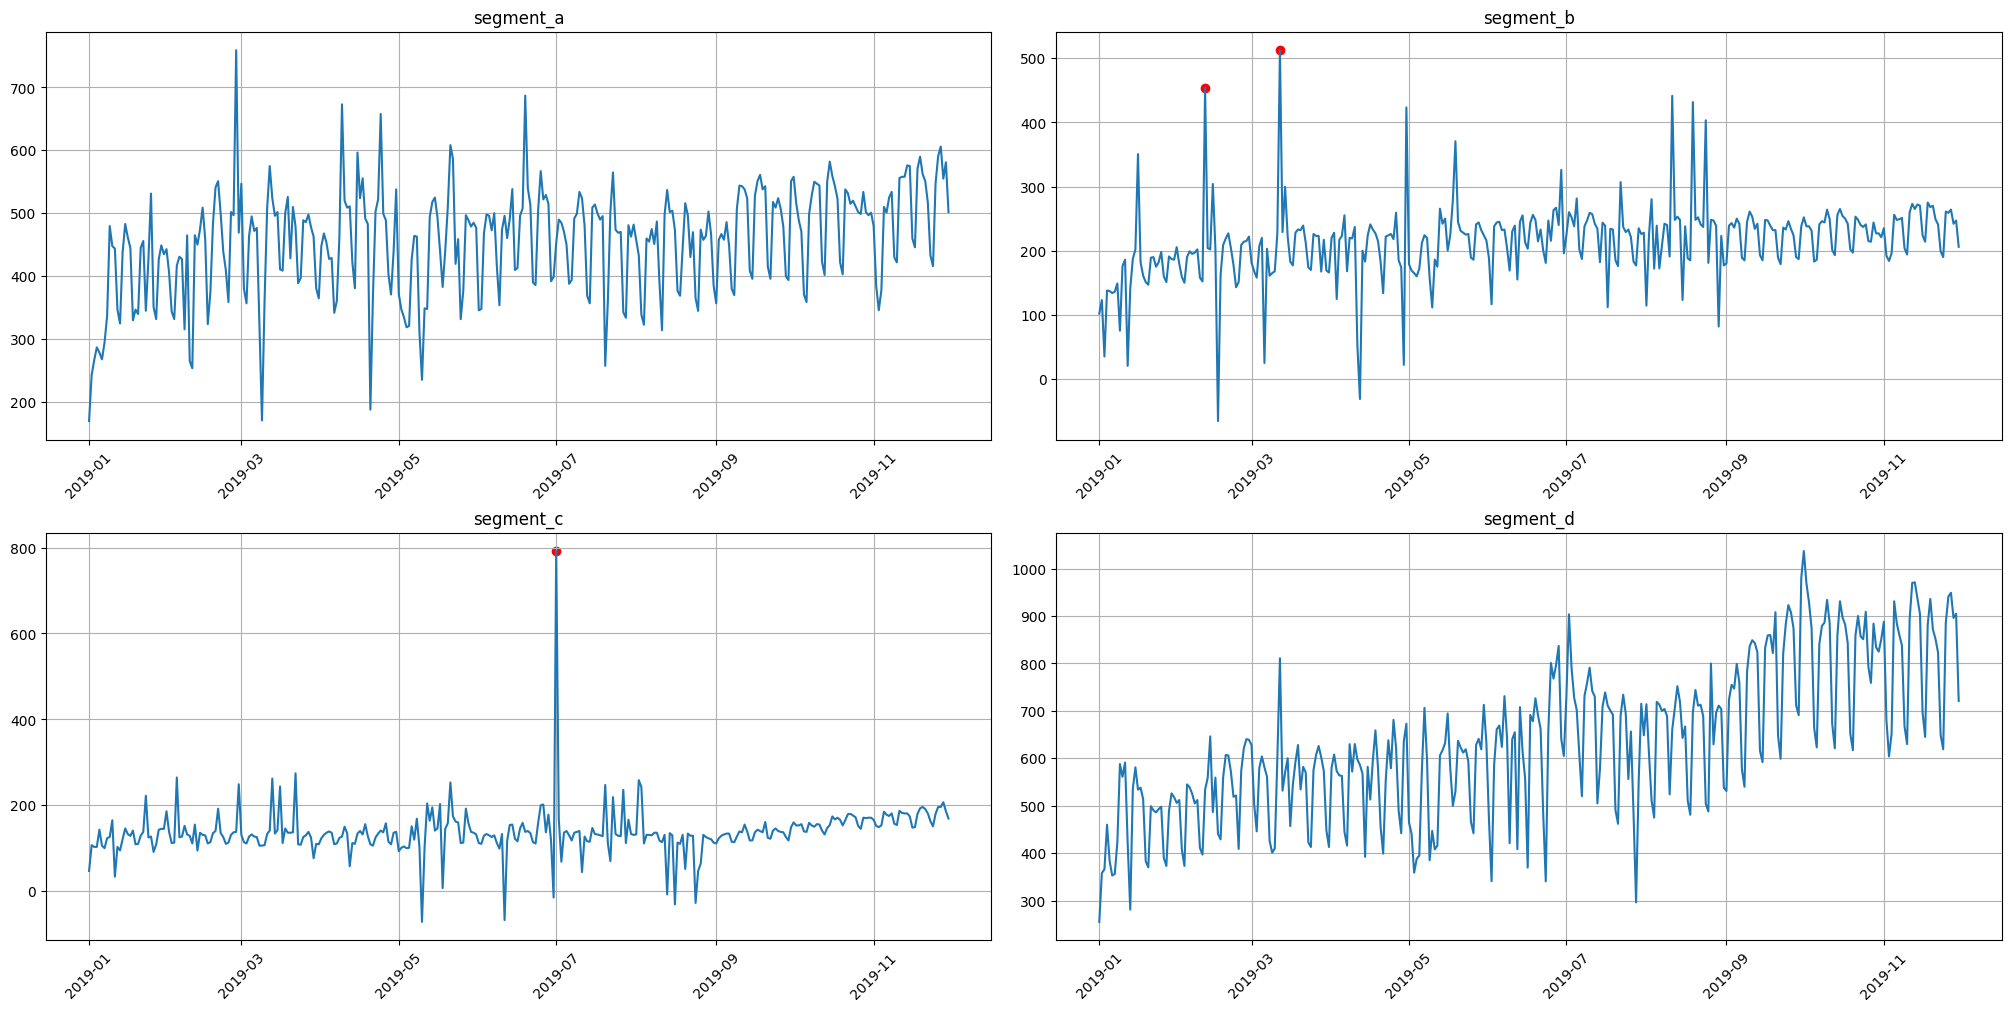

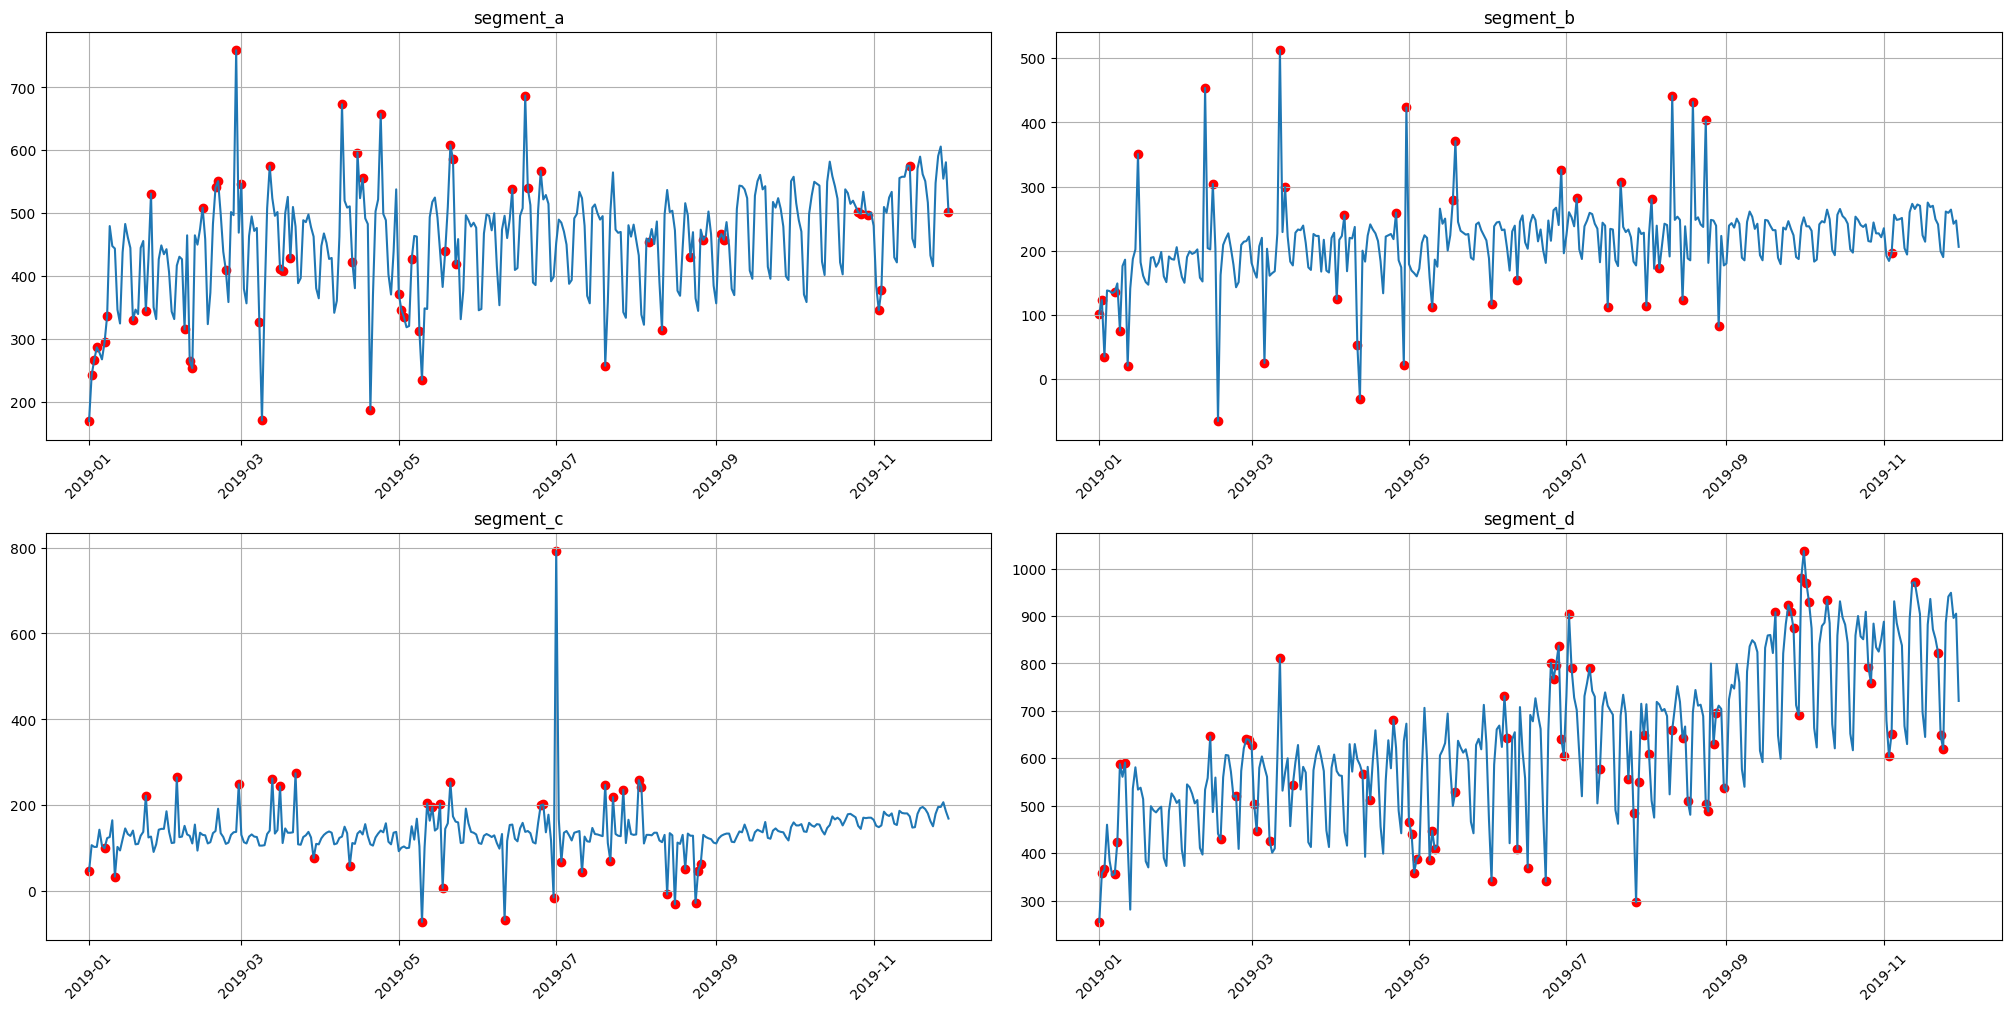

In [52]:
from etna.analysis import plot_anomalies
from etna.analysis import get_anomalies_median, get_anomalies_density, get_anomalies_prediction_interval
from etna.datasets import TSDataset

# 1. Выявление аномалий с использованием медианного метода
anomalies_median = get_anomalies_median(
    ts=ts,
    in_column="target",
    window_size=19,  # Размер окна для медианного сглаживания
    alpha=3.2       # Коэффициент чувствительности
)

# 2. Выявление аномалий на основе плотности
anomalies_density = get_anomalies_density(
    ts=ts,
    in_column="target",
    distance_coef=3.9  # Коэффициент для поиска аномалий
)

# 3. Выявление аномалий на основе предиктивного интервала
anomalies_prediction_interval = get_anomalies_prediction_interval(
    ts=ts,
    in_column="target",
    model=ProphetModel,  # Модель для предсказания
    interval_width=0.675    # Доверительный интервал
)

# Визуализация аномалий
print("Визуализация аномалий на основе медианы:")
plot_anomalies(ts, anomalies_median)

print("Визуализация аномалий на основе плотности:")
plot_anomalies(ts, anomalies_density)

print("Визуализация аномалий на основе предиктивного интервала:")
plot_anomalies(ts, anomalies_prediction_interval)
